In [1]:
from td.client import TDClient
import numpy as np
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt


In [2]:

from api_info import client_id, redirect_uri

TDSession = TDClient(
    client_id=client_id,
    redirect_uri=redirect_uri,
    credentials_path='./td_state.json'
)

# Login to the session
TDSession.login()


Grabbing new access token...


True

In [3]:
TICKER = "MU"
PERIOD_TYPE = 'year'
NUM_PERIOD = 3
stock_history = TDSession.get_price_history(
    TICKER, extended_hours=False, period=NUM_PERIOD, period_type=PERIOD_TYPE, frequency=1, frequency_type='daily')


In [4]:
stock_df = pd.DataFrame(stock_history).drop(columns=['empty', 'symbol'])


In [5]:
# Replace candles column with corresponding open, high, low, etc columns
stock_flat_df = pd.concat([stock_df.drop(columns=['candles']), pd.DataFrame(
    stock_df.candles.values.tolist())], axis=1)
stock_flat_df['datetime_formatted'] = pd.to_datetime(
    stock_flat_df['datetime'], unit='ms')

stock_flat_df['returns'] = stock_flat_df.close.pct_change()

stock_flat_df.dropna(inplace=True)
print(stock_flat_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 1 to 755
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open                755 non-null    float64       
 1   high                755 non-null    float64       
 2   low                 755 non-null    float64       
 3   close               755 non-null    float64       
 4   volume              755 non-null    int64         
 5   datetime            755 non-null    int64         
 6   datetime_formatted  755 non-null    datetime64[ns]
 7   returns             755 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 53.1 KB
None


In [6]:
stock_flat_df['rsi'] = pta.rsi(stock_flat_df['close'], length=14)


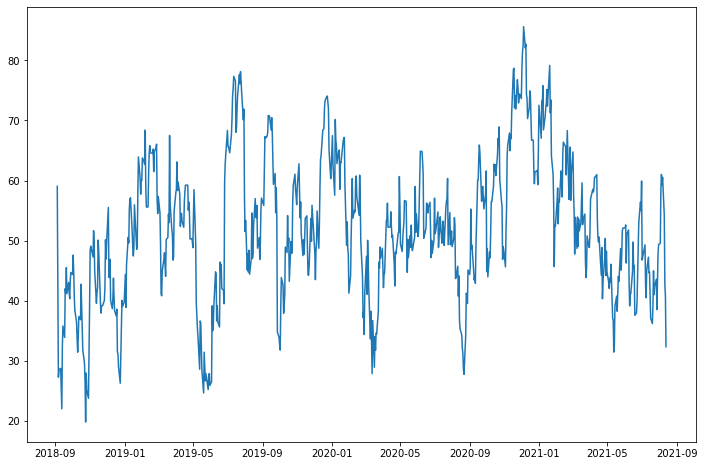

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(stock_flat_df.datetime_formatted, stock_flat_df.rsi)
plt.show()


In [8]:
def backtest_report(input_trades, params):
    trades = pd.DataFrame(input_trades)
    winning_trades = trades.loc[trades.pl > 0]
    losing_trades = trades.loc[trades.pl < 0]

    if (trades.shape[0] > 0):
        avg_pl = np.average(trades.pl / (trades.buy_price * trades.shares_sold) * 100)
    else:
        avg_pl = 0
    
    if (winning_trades.shape[0] > 0):
        avg_profit = np.average(
            winning_trades.pl / (winning_trades.buy_price * winning_trades.shares_sold) * 100)
    else:
        avg_profit = 0

    if (losing_trades.shape[0] > 0):
        avg_loss = np.average(
            losing_trades.pl / (losing_trades.buy_price * losing_trades.shares_sold) * 100)
    else:
        avg_loss = 0

    pct_win = winning_trades.shape[0] / trades.shape[0] * 100
    total_profit = trades.pl.sum()
    total_days_holding = (trades.sell_date - trades.buy_date).dt.days.sum()
    total_days = stock_flat_df.shape[0]
    

    report = {"average_pl_pct": avg_pl, "Average_Profit_pct": avg_profit, "Average_Loss_pct": avg_loss,
              "Winning_pct": pct_win, "trade_count": trades.shape[0], "total_profit_pct": total_profit / starting_capital * 100,
              "Market_Exposure_pct": total_days_holding / total_days * 100, 'max_trade_drawdowns': trades.max_drawdown.values}
    
    for k,v in params.items():
        report[k] = v

    return report


In [9]:
pd.options.mode.chained_assignment = None  # default='warn'
rsi_lower_range = range(15, 40, 5)
rsi_upper_range = range(40, 95, 5)

def create_signals(rsi_lower, rsi_upper):
    stock_flat_df['buy'] = 0
    stock_flat_df.buy[stock_flat_df.rsi <= rsi_lower] = 1
    stock_flat_df.buy[stock_flat_df.rsi >= rsi_upper] = -1


def backtest(starting_capital, long_only=True):
    trades = []
    capital = starting_capital
    owned_shares = 0
    trade_count = 0
    buy_price = stock_flat_df.close.iloc[0]
    buy_date = None
    trade_drawdown = 0
    sell_price = 0
    
    for idx in stock_flat_df.index:
        sell_price = stock_flat_df.close[idx]
        trade_drawdown = max(trade_drawdown, (1 - sell_price / buy_price) * 100)
        
        if stock_flat_df.buy[idx] == 1 and capital >= stock_flat_df.close[idx]:
            buy_price = sell_price
            shares_bought = int(capital / sell_price)
            capital -= shares_bought * sell_price
            owned_shares += shares_bought
            buy_date = stock_flat_df.datetime_formatted[idx]
            trade_drawdown = 0
        elif stock_flat_df.buy[idx] == -1 and owned_shares > 0:
            capital += owned_shares * sell_price
            trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'buy_date': buy_date.date(), 'sell_date': stock_flat_df.datetime_formatted[idx].date(),
                           'shares_sold': owned_shares, 'pl': (sell_price - buy_price) * owned_shares, 'max_drawdown': trade_drawdown})
            owned_shares = 0   
            trade_count += 1    
            
    if owned_shares > 0:
        capital += owned_shares * sell_price
        trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'buy_date': buy_date.date(), 'sell_date': stock_flat_df.datetime_formatted[idx].date(),
                       'shares_sold': owned_shares, 'pl': (sell_price - buy_price) * owned_shares, 'max_drawdown': trade_drawdown})
        owned_shares = 0
        trade_count += 1

    return capital, owned_shares, trade_count, trades

starting_capital = 100000
best_params = ()
worst_params = ()

best_capital = 0
worst_capital = 100000000000000
best_trade_count = 0
reports = []
all_trades = {}

for rsi_low in rsi_lower_range:
    for rsi_up in rsi_upper_range:
        create_signals(rsi_low, rsi_up)
        capital, owned_shares, trade_count, trades = backtest(starting_capital)

        all_trades[(rsi_low, rsi_up)] = trades

        if capital > best_capital:
            best_capital = capital
            best_params = (rsi_low, rsi_up)
        elif capital < worst_capital:
            capital = worst_capital
            worst_params = (rsi_low, rsi_up)
        
        if (len(trades) > 0):
            reports.append(backtest_report(trades, {'rsi_low': rsi_low, 'rsi_up': rsi_up}))

print(best_params)
print(worst_params)


(20, 85)
(35, 90)


In [10]:
def plot_trades(trades, label):
    plt.figure(figsize=(20, 12))
    for idx in range(trades.shape[0]):
        bt = trades.iloc[idx]
        plt.scatter(bt.buy_date, bt.buy_price, marker='P', c='black', s=100)
        plt.scatter(bt.sell_date, bt.sell_price, marker='X', c='red', s=100)

    plt.plot(stock_flat_df.datetime_formatted, stock_flat_df.close, c='green')
    plt.title(label)
    plt.show()


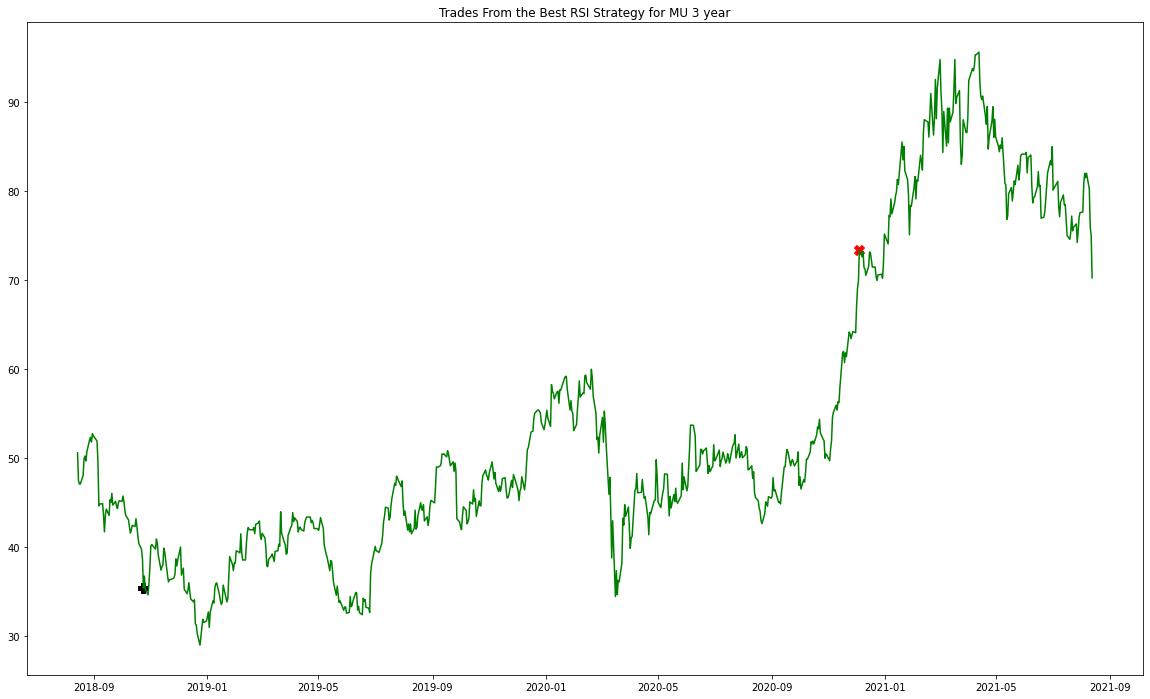

In [11]:
best_trades_df = pd.DataFrame(all_trades[best_params])
plot_trades(best_trades_df,
            f"Trades From the Best RSI Strategy for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")


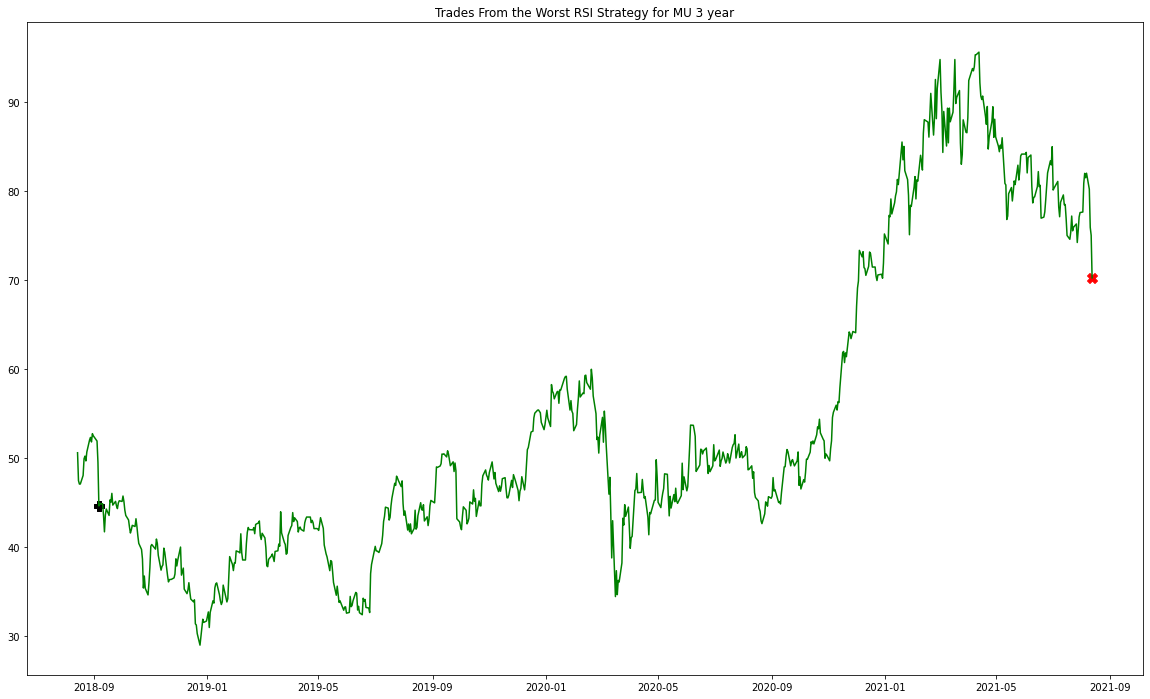

In [12]:
worst_trades_df = pd.DataFrame(all_trades[worst_params])

plot_trades(worst_trades_df,
            f"Trades From the Worst RSI Strategy for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")

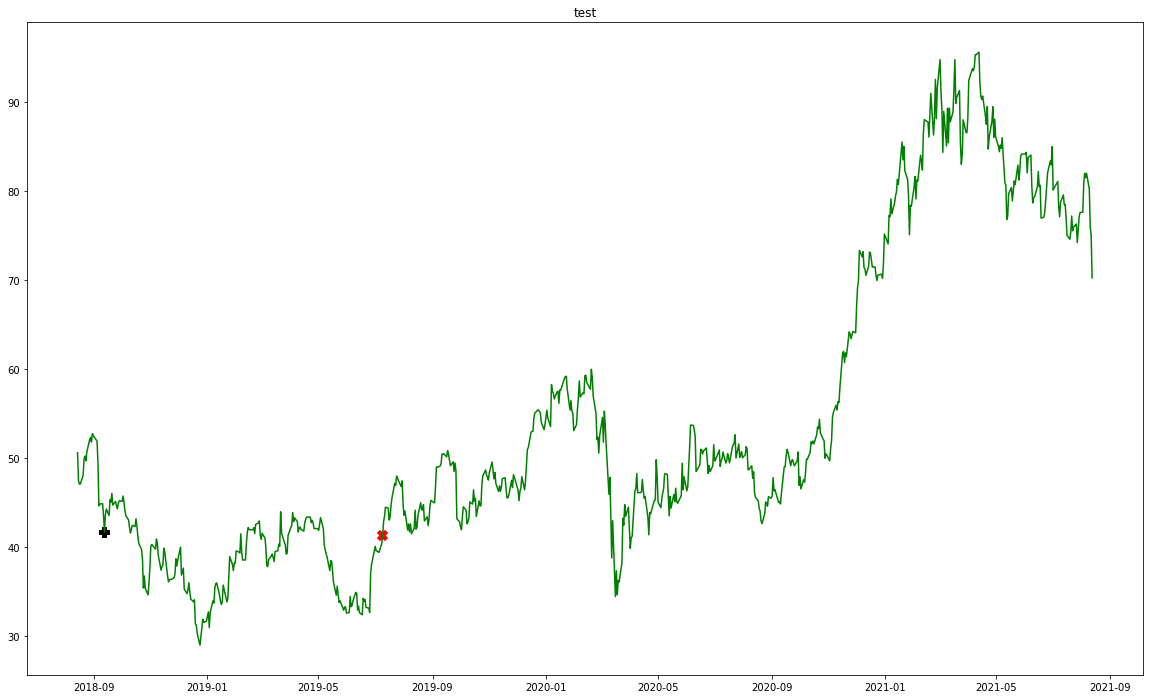

In [13]:
specific_trades_df = pd.DataFrame(all_trades[(25, 70)])
plot_trades(specific_trades_df, "test")

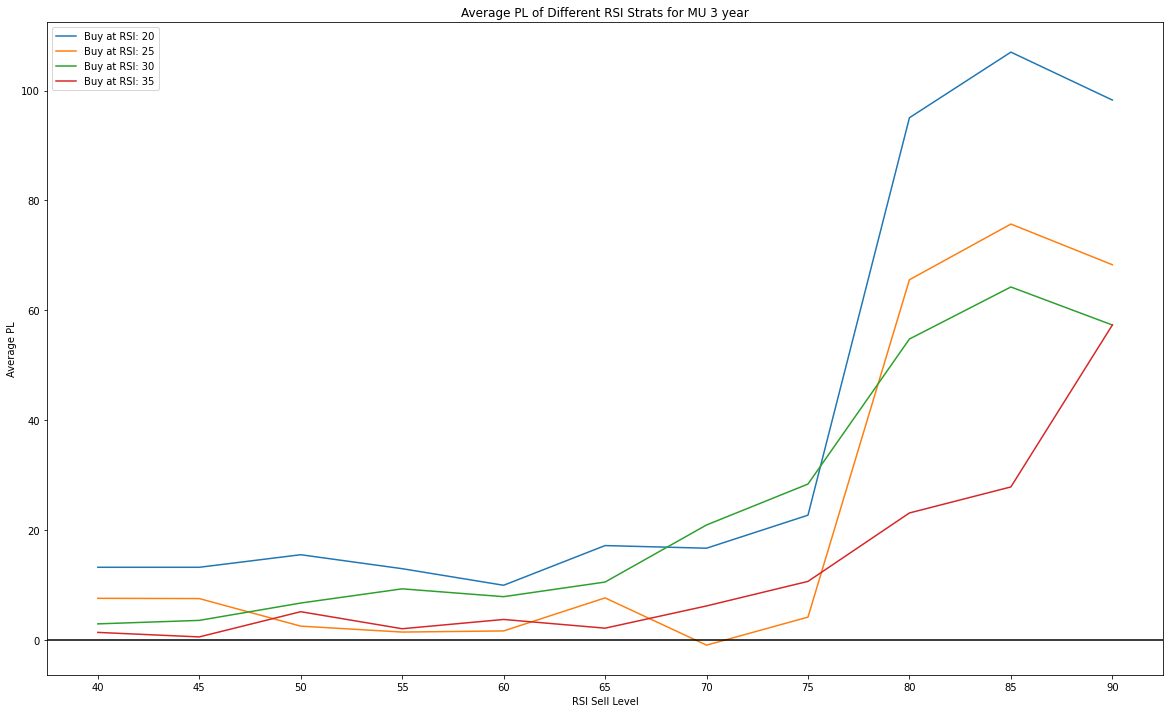

In [14]:
reports_df = pd.DataFrame(reports)

reports_df['max_drawdown'] = reports_df.max_trade_drawdowns.map(np.max)
reports_df['avg_drawdown'] = reports_df.max_trade_drawdowns.map(np.average)

plt.figure(figsize=(20, 12))
for rs in rsi_lower_range:
    subset = reports_df[reports_df.rsi_low == rs]
    if (subset.shape[0] == 0):
        continue

    plt.plot(subset.rsi_up, subset.average_pl_pct,
             label=f'Buy at RSI: {rs}')

plt.title(
    f"Average PL of Different RSI Strats for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")
plt.ylabel("Average PL")
plt.xlabel("RSI Sell Level")
plt.xticks(rsi_upper_range)
plt.legend()
plt.axhline(0, c='black')
plt.show()


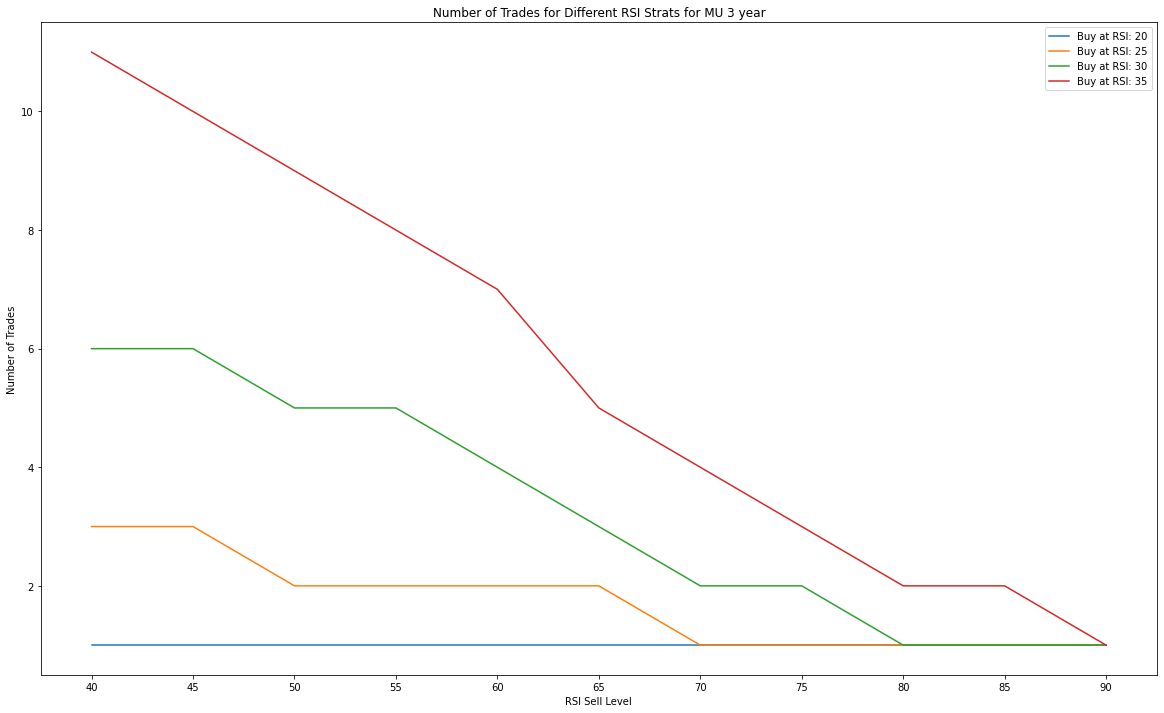

In [15]:
plt.figure(figsize=(20, 12))
for rs in rsi_lower_range:
    subset = reports_df[reports_df.rsi_low == rs]
    if (subset.shape[0] == 0):
        continue

    plt.plot(subset.rsi_up, subset.trade_count,
             label=f'Buy at RSI: {rs}')

plt.title(
    f"Number of Trades for Different RSI Strats for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")
plt.ylabel("Number of Trades")
plt.xlabel("RSI Sell Level")
plt.xticks(rsi_upper_range)
plt.legend()
plt.show()

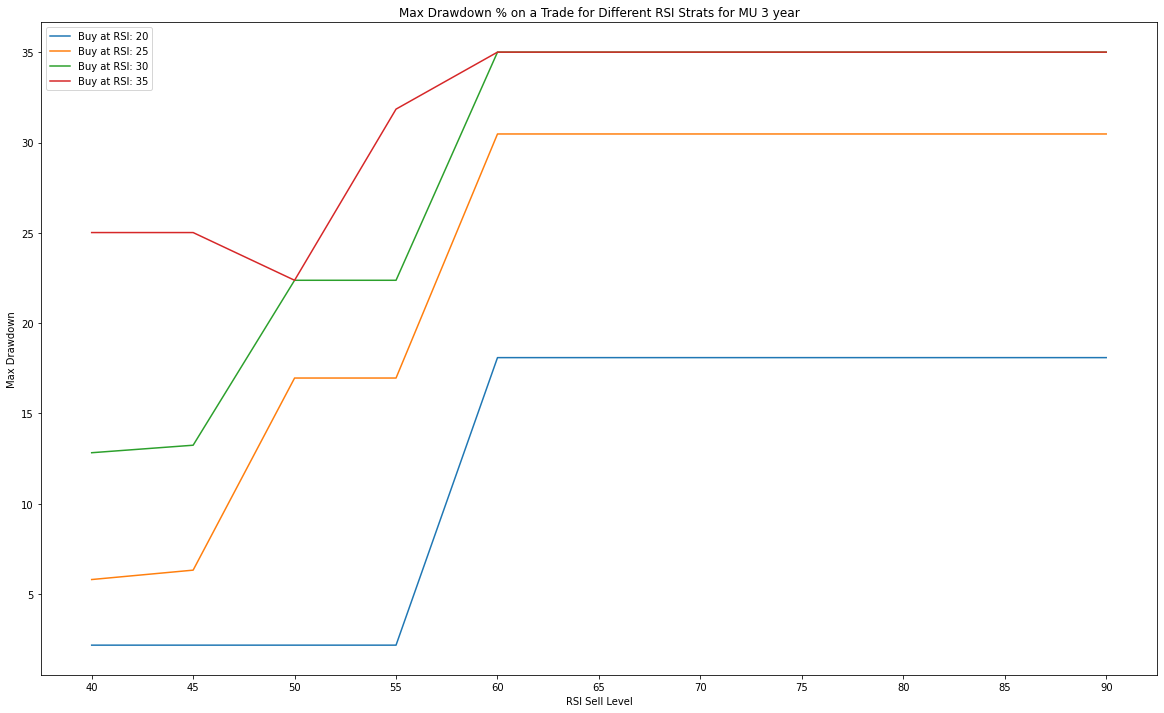

In [16]:
plt.figure(figsize=(20, 12))
for rs in rsi_lower_range:
    subset = reports_df[reports_df.rsi_low == rs]
    if (subset.shape[0] == 0):
        continue

    plt.plot(subset.rsi_up, subset.max_drawdown,
             label=f'Buy at RSI: {rs}')

plt.title(
    f"Max Drawdown % on a Trade for Different RSI Strats for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")
plt.ylabel("Max Drawdown")
plt.xlabel("RSI Sell Level")
plt.xticks(rsi_upper_range)
plt.legend()
plt.show()


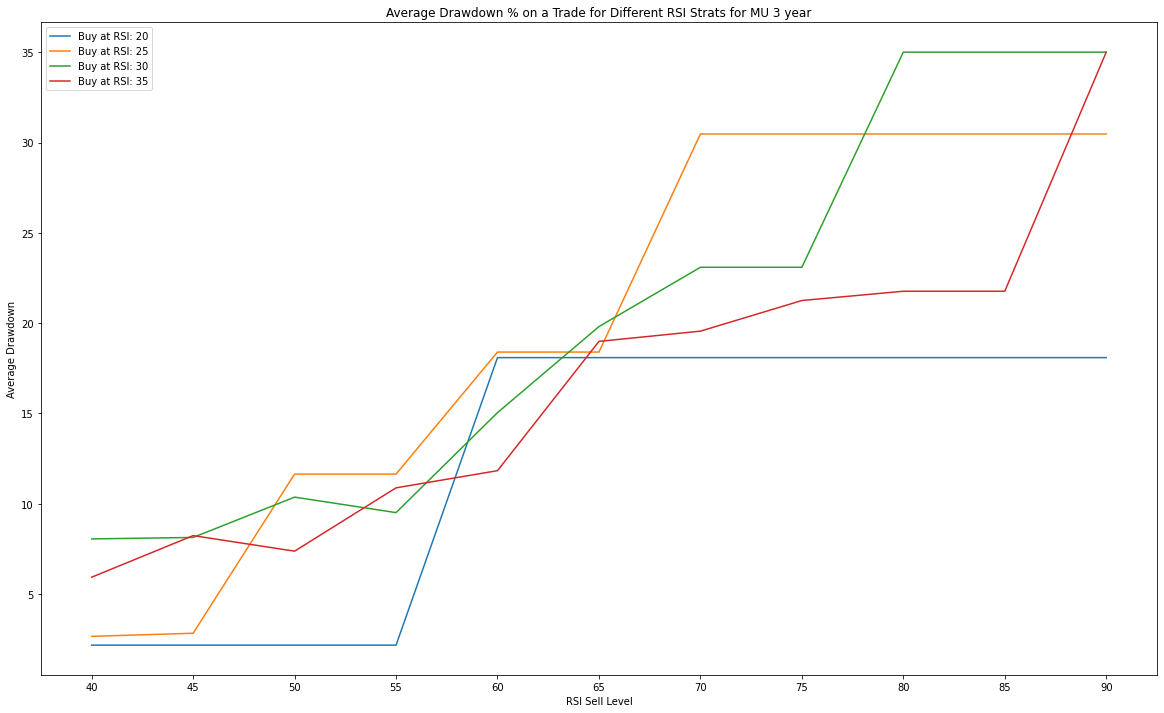

In [17]:
plt.figure(figsize=(20, 12))
for rs in rsi_lower_range:
    subset = reports_df[reports_df.rsi_low == rs]
    if (subset.shape[0] == 0):
        continue

    plt.plot(subset.rsi_up, subset.avg_drawdown,
             label=f'Buy at RSI: {rs}')

plt.title(
    f"Average Drawdown % on a Trade for Different RSI Strats for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")
plt.ylabel("Average Drawdown")
plt.xlabel("RSI Sell Level")
plt.xticks(rsi_upper_range)
plt.legend()
plt.show()

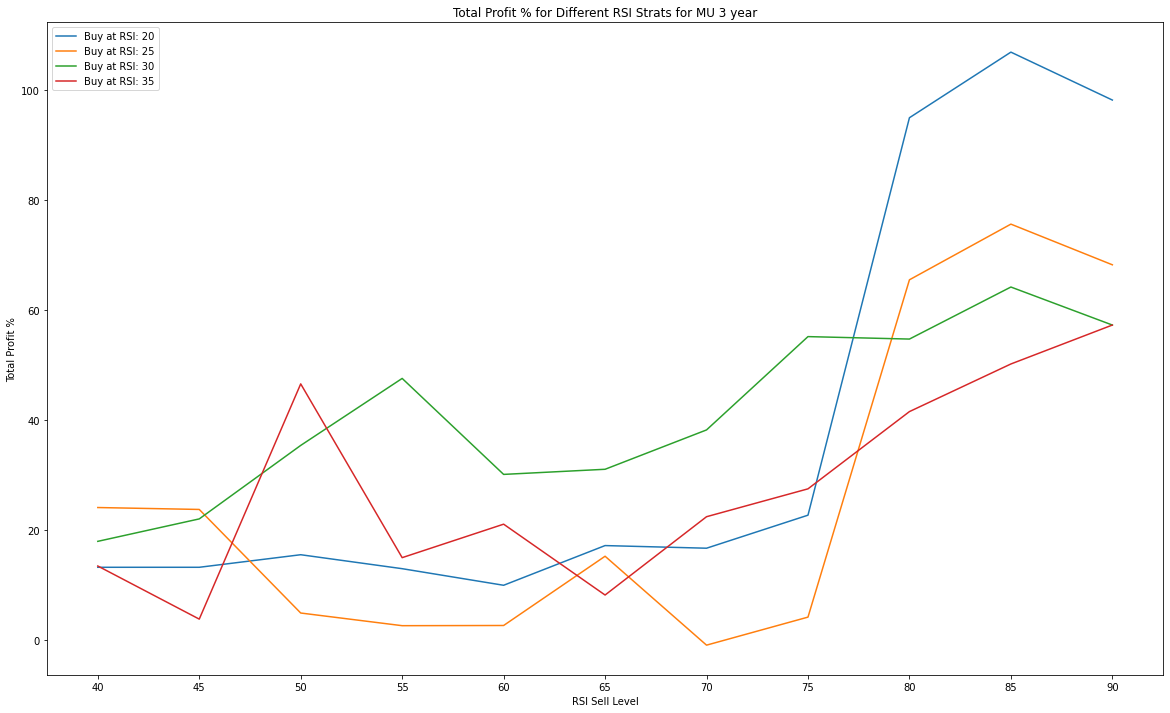

In [18]:
plt.figure(figsize=(20, 12))
for rs in rsi_lower_range:
    subset = reports_df[reports_df.rsi_low == rs]
    if (subset.shape[0] == 0):
        continue

    plt.plot(subset.rsi_up, subset.total_profit_pct,
             label=f'Buy at RSI: {rs}')

plt.title(
    f"Total Profit % for Different RSI Strats for {TICKER} {NUM_PERIOD} {PERIOD_TYPE}")
plt.ylabel("Total Profit %")
plt.xlabel("RSI Sell Level")
plt.xticks(rsi_upper_range)
plt.legend()
plt.show()